In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

from sklearn.metrics.pairwise import cosine_similarity

import pickle

: 

In [2]:
pd.set_option('display.max_colwidth', None)

# 1. Data 

### 1.1 Data Preparation

In [3]:
path = "../store_data.csv"

In [4]:
df = pd.read_csv(path)

In [5]:
df.head() # Example

,ChequeLineID,ChequeID,DiscountCardID,CustomerID,Time,ItemID,Name,Quantity
0,1018569570,184300374,70a693b755,640629cfd5,2025-02-01 12:48:42,108859,"Напиток Positivity Мохито классич. б/а газ. 0,45л ж/б",1
1,1018402483,184283352,481e4dc097,e16ae2b23c,2025-02-01 10:41:19,8223,Сметана ВМ 15% 170г,1
2,1018824249,184324873,29668b3b35,1d10175438,2025-02-01 15:16:36,77021,Хлеб Солдатский 320г,1
3,1018824246,184324873,29668b3b35,1d10175438,2025-02-01 15:16:36,2226,Лимоны вес,0.188
4,1018824247,184324873,29668b3b35,1d10175438,2025-02-01 15:16:36,77021,Хлеб Солдатский 320г,1


In [14]:
for col in df.columns:
    print(f"{col} - {df[col].nunique()}")

ChequeLineID - 271998
ChequeID - 37293
DiscountCardID - 9815
CustomerID - 9601
Time - 36953
ItemID - 14040
Name - 14024
Quantity - 2360


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271998 entries, 0 to 271997
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ChequeLineID    271998 non-null  int64 
 1   ChequeID        271998 non-null  int64 
 2   DiscountCardID  226361 non-null  object
 3   CustomerID      223976 non-null  object
 4   Time            271998 non-null  object
 5   ItemID          271998 non-null  int64 
 6   Name            271998 non-null  object
 7   Quantity        271998 non-null  object
dtypes: int64(3), object(5)
memory usage: 16.6+ MB


In [39]:
df.isnull().sum()

ChequeLineID          0
ChequeID              0
DiscountCardID    45637
CustomerID        48022
Time                  0
ItemID                0
Name                  0
Quantity              0
dtype: int64

In [6]:
# TO GET list[str]
data = df.groupby('ChequeID')['Name'].apply(list).reset_index()

# TO GET str
# data = df.groupby('ChequeID')['Name'].apply(','.join).reset_index()

In [41]:
data.columns = ['ChequeID', 'Items']
data.head()

,ChequeID,Items
0,184272739,"[Вода №1 стол. б/г 1л п/б, Семечки тыквенные о..."
1,184272835,"[Снеки курут Байэл домашний 30г в/у, Жев. рези..."
2,184273020,[Орехи Big Bob Арахис соленый 170г п/п]
3,184273031,[Лимоны вес]
4,184273073,[Кофе MacCoffee 3в1 20г саше]


### 1.2 Data Analysis

In [15]:
df_TimeSeries = df.copy()
df_TimeSeries['Time'] = pd.to_datetime(df_TimeSeries['Time'])
df_TimeSeries.set_index('Time', inplace=True)

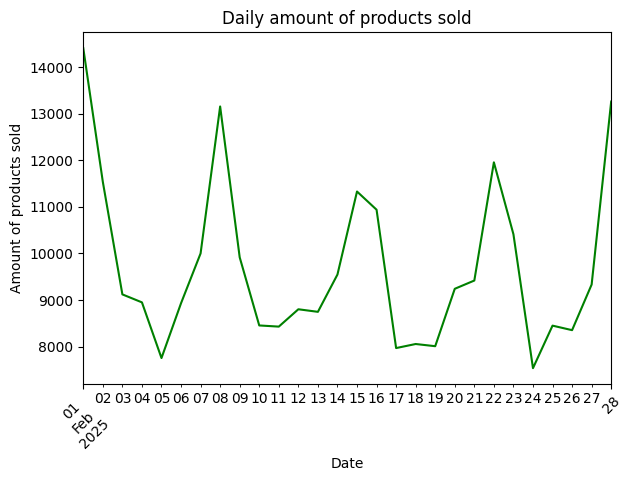

In [27]:
df_TimeSeries.resample('D').size().plot(color='green')
plt.title('Daily amount of products sold')
plt.xlabel('Date')
plt.ylabel('Amount of products sold')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [33]:
daily_sales_per_cheque = df_TimeSeries.groupby('ChequeID').resample('D').size().groupby('Time').size()

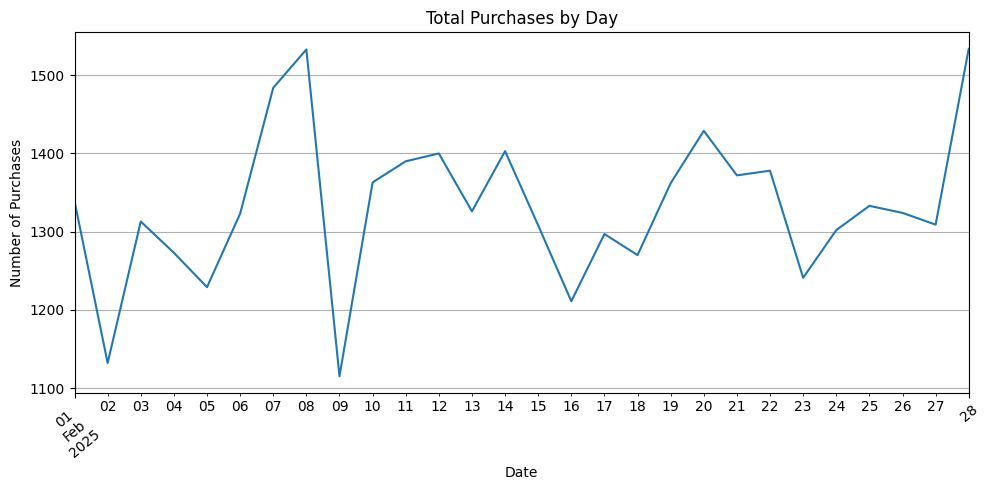

In [36]:
plt.figure(figsize=(10, 5))
daily_sales_per_cheque.plot(title='Total Purchases by Day')
plt.xlabel('Date')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=40)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Modeling

### 2.1 Associative rules (Apriori)

In [55]:
dt = df[~df['Name'].str.lower().str.contains('пакет глобус', na=False)]

In [56]:
df

,ChequeLineID,ChequeID,DiscountCardID,CustomerID,Time,ItemID,Name,Quantity
0,1018569570,184300374,70a693b755,640629cfd5,2025-02-01 12:48:42,108859,"Напиток Positivity Мохито классич. б/а газ. 0,...",1
1,1018402483,184283352,481e4dc097,e16ae2b23c,2025-02-01 10:41:19,8223,Сметана ВМ 15% 170г,1
2,1018824249,184324873,29668b3b35,1d10175438,2025-02-01 15:16:36,77021,Хлеб Солдатский 320г,1
3,1018824246,184324873,29668b3b35,1d10175438,2025-02-01 15:16:36,2226,Лимоны вес,0.188
4,1018824247,184324873,29668b3b35,1d10175438,2025-02-01 15:16:36,77021,Хлеб Солдатский 320г,1
...,...,...,...,...,...,...,...,...
271993,1052928832,188255899,NaN,NaN,2025-02-28 17:35:02,109507,Сигареты Esse Sense Himalaya,1
271994,1052869756,188250339,NaN,NaN,2025-02-28 17:08:36,117678,Филе Тилапии заморож. вес в/у NEW,0.364
271995,1052601691,188223643,NaN,NaN,2025-02-28 14:42:14,68802,"Нектар Солнечный тропик 1,9л т/п",1
271996,1053203015,188279078,NaN,NaN,2025-02-28 19:20:37,19977,Стакан однораз прозр 200мл 1шт,4


In [22]:
dt

,ChequeLineID,ChequeID,DiscountCardID,CustomerID,Time,ItemID,Name,Quantity
0,1018569570,184300374,70a693b755,640629cfd5,2025-02-01 12:48:42,108859,"Напиток Positivity Мохито классич. б/а газ. 0,...",1
1,1018402483,184283352,481e4dc097,e16ae2b23c,2025-02-01 10:41:19,8223,Сметана ВМ 15% 170г,1
2,1018824249,184324873,29668b3b35,1d10175438,2025-02-01 15:16:36,77021,Хлеб Солдатский 320г,1
3,1018824246,184324873,29668b3b35,1d10175438,2025-02-01 15:16:36,2226,Лимоны вес,0.188
4,1018824247,184324873,29668b3b35,1d10175438,2025-02-01 15:16:36,77021,Хлеб Солдатский 320г,1
...,...,...,...,...,...,...,...,...
271993,1052928832,188255899,NaN,NaN,2025-02-28 17:35:02,109507,Сигареты Esse Sense Himalaya,1
271994,1052869756,188250339,NaN,NaN,2025-02-28 17:08:36,117678,Филе Тилапии заморож. вес в/у NEW,0.364
271995,1052601691,188223643,NaN,NaN,2025-02-28 14:42:14,68802,"Нектар Солнечный тропик 1,9л т/п",1
271996,1053203015,188279078,NaN,NaN,2025-02-28 19:20:37,19977,Стакан однораз прозр 200мл 1шт,4


In [57]:
baskets = dt.groupby('ChequeID')['Name'].apply(list)

In [58]:
baskets = pd.concat([baskets] * 10, ignore_index=True)

In [59]:
baskets.shape

(371190,)

In [ ]:
te = TransactionEncoder()
te_array = te.fit(baskets).transform(baskets)   
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

In [61]:
df_encoded

,AVS SPP-01 авто сүргүчү,AVS WT-004 авариялык токтоо белгиси,AVS микрофибра авто тазалоочу салфеткасы,AVS шар ачкычы 21мм,Doctor Clean лимон идиш жуугуч каражаты 650мл,Grunch Time жүгөр.шариктери лесн.ягоды 170г,Maggi на 2-е для макарон 1+1 (сыр/кур/грибы)+роллтон перья,SPAR бав.горч.180г ст/б,Sterill confetto унив жыйналган сүлгүлөр 20даана,Sterill унив жумшак сүлгүлөр 60даана,...,Яйцо пласт. L.O.L. Surprise мармелад ягодный с игрушкой 30г,Яйцо пласт. Mozzy и ее веселые пони жеват. клубника 7г,Яйцо пласт. Naruto Shippuden хрус. шарики с игрушкой 75г,Яйцо пласт. Крутой дрифт хрус. шарики с игрушкой 10г,Яйцо шок. L.O.L. Surprise капсула 20г,Яйцо шок. Naruto Shippuden с игрушкой 20г,Яйцо шок. Крутой вираж машинка 20г,Яйцо шок. Милые безделушки для девочки 20г,Яйцо шок. Твоя армия воен. машинка 20г,рулетка Stayer 3м
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371185,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
371186,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
371187,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
371188,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [62]:
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

In [63]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

In [64]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Бананы высший сорт),(Морковь мытая),0.104636,0.036316,0.010372,0.099125,2.729530,1.0,0.006572,1.069720,0.707686,0.079431,0.065176,0.192366
1,(Морковь мытая),(Бананы высший сорт),0.036316,0.104636,0.010372,0.285608,2.729530,1.0,0.006572,1.253323,0.657515,0.079431,0.202121,0.192366
2,(Картофель),(Лук репчатый),0.027479,0.031628,0.011288,0.410784,12.987992,1.0,0.010419,1.643493,0.949086,0.236056,0.391540,0.383842
3,(Лук репчатый),(Картофель),0.031628,0.027479,0.011288,0.356899,12.987992,1.0,0.010419,1.512238,0.953152,0.236056,0.338728,0.383842
4,(Лук репчатый),(Морковь мытая),0.031628,0.036316,0.011962,0.378194,10.414088,1.0,0.010813,1.549816,0.933501,0.213667,0.354762,0.353786


In [65]:
rules = rules.sort_values(by='lift', ascending=False)

In [ ]:
def recommend_best_product(item_list, rules_df, excluded_items=None):
    if not isinstance(item_list, list):
        raise ValueError("Input must be a list of item names.")

    if excluded_items is None:
        excluded_items = {'Пакет', 'пакет глобус', 'Bag', 'Plastic bag', 'Paper Bag', 'Receipt'}

    strong_matches = rules_df[rules_df['antecedents'].apply(lambda x: x.issubset(item_list))]

    if strong_matches.empty:
        strong_matches = rules_df[rules_df['antecedents'].apply(lambda x: any(i in item_list for i in x))]

    strong_matches = strong_matches.sort_values(by='lift', ascending=False)

    for _, row in strong_matches.iterrows():
        for product in row['consequents']:
            if product not in item_list and not any(bad in product.lower() for bad in excluded_items):
                return product

    return None 


In [75]:
items_in_cart = ['Хлеб Солдатский 320г']
best_product = recommend_best_product(items_in_cart, rules)

if best_product:
    print(f"Customers who bought {items_in_cart} also bought: {best_product}")
else:
    print(f"No complementary product found for items: {items_in_cart}")

No complementary product found for items: ['Хлеб Солдатский 320г']


In [69]:
df['Name'].unique()

array(['Напиток Positivity Мохито классич. б/а газ. 0,45л ж/б',
       'Сметана ВМ 15% 170г', 'Хлеб Солдатский 320г', ...,
       "Чизкейк Betty's Cake Нью-Йорк 100г",
       'Йогурт Альпенгурт Сочный-молочный с соком абр/манго 1,2% 95г',
       'Филе Тилапии заморож. вес в/у NEW'], dtype=object)

### 2.2 Colaborative filtering (User-Based)

In [7]:
df.head(10)

,ChequeLineID,ChequeID,DiscountCardID,CustomerID,Time,ItemID,Name,Quantity
0,1018569570,184300374,70a693b755,640629cfd5,2025-02-01 12:48:42,108859,"Напиток Positivity Мохито классич. б/а газ. 0,45л ж/б",1
1,1018402483,184283352,481e4dc097,e16ae2b23c,2025-02-01 10:41:19,8223,Сметана ВМ 15% 170г,1
2,1018824249,184324873,29668b3b35,1d10175438,2025-02-01 15:16:36,77021,Хлеб Солдатский 320г,1
3,1018824246,184324873,29668b3b35,1d10175438,2025-02-01 15:16:36,2226,Лимоны вес,0.188
4,1018824247,184324873,29668b3b35,1d10175438,2025-02-01 15:16:36,77021,Хлеб Солдатский 320г,1
5,1018824248,184324873,29668b3b35,1d10175438,2025-02-01 15:16:36,77021,Хлеб Солдатский 320г,1
6,1019056381,184346736,4506f48f15,2d946696f2,2025-02-01 17:22:07,115771,Прокладки гиг Villa с запахом премиум 10шт,2
7,1019056388,184346736,4506f48f15,2d946696f2,2025-02-01 17:22:07,115702,Яйцо куриное Столичное 10шт С1,1
8,1018402489,184283352,481e4dc097,e16ae2b23c,2025-02-01 10:41:19,117124,Коктейль молочный Riki банан 2% 250г,1
9,1019056379,184346736,4506f48f15,2d946696f2,2025-02-01 17:22:07,25846,Хлеб Картофельный с луком 300г СП,1


In [21]:
def safe_convert(x):
    try:
        val = float(x)
        return 1 if val != int(val) else int(val)
    except ValueError:
        return None

df['Quantity'] = df['Quantity'].apply(safe_convert).value_counts()

In [22]:
transactions_data = data.copy()
transactions_data.head(3)

,ChequeID,Name
0,184272739,"[Вода №1 стол. б/г 1л п/б, Семечки тыквенные о..."
1,184272835,"[Снеки курут Байэл домашний 30г в/у, Жев. рези..."
2,184273020,[Орехи Big Bob Арахис соленый 170г п/п]


In [23]:
user_item_matrix = pd.pivot_table(df, 
               index='CustomerID',
               columns='Name',
               values='Quantity',
               aggfunc='sum',
               fill_value=0)

In [24]:
user_item_matrix

Name,AVS SPP-01 авто сүргүчү,AVS WT-004 авариялык токтоо белгиси,AVS микрофибра авто тазалоочу салфеткасы,Doctor Clean лимон идиш жуугуч каражаты 650мл,Grunch Time жүгөр.шариктери лесн.ягоды 170г,Maggi на 2-е для макарон 1+1 (сыр/кур/грибы)+роллтон перья,SPAR бав.горч.180г ст/б,Sterill confetto унив жыйналган сүлгүлөр 20даана,Sterill унив жумшак сүлгүлөр 60даана,Tammi кычкыл кола мармелады 150г.,...,Яйцо пласт. Hello Kitty драже сах. клубника 10г,Яйцо пласт. Hello Kitty хрус. шарики с игрушкой большой 15г,Яйцо пласт. L.O.L. Surprise мармелад ягодный с игрушкой 30г,Яйцо пласт. Mozzy и ее веселые пони жеват. клубника 7г,Яйцо пласт. Naruto Shippuden хрус. шарики с игрушкой 75г,Яйцо шок. L.O.L. Surprise капсула 20г,Яйцо шок. Naruto Shippuden с игрушкой 20г,Яйцо шок. Милые безделушки для девочки 20г,Яйцо шок. Твоя армия воен. машинка 20г,рулетка Stayer 3м
CustomerID,,,,,,,,,,,,,,,,,,,,,
0.00E+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000c97204c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002126f500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002ae45668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002b4bc775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffd494590f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffe5b3f80b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffefd02d7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
user_similarity = cosine_similarity(user_item_matrix)
user_similarity

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)
print(user_similarity_df.head())

CustomerID  0.00E+00  000c97204c  002126f500  002ae45668  002b4bc775  \
CustomerID                                                             
0.00E+00         0.0         0.0         0.0         0.0         0.0   
000c97204c       0.0         0.0         0.0         0.0         0.0   
002126f500       0.0         0.0         0.0         0.0         0.0   
002ae45668       0.0         0.0         0.0         0.0         0.0   
002b4bc775       0.0         0.0         0.0         0.0         0.0   

CustomerID  002ba1eb55  002d03d374  002dac5d81  003b88c74e  00406bbe77  ...  \
CustomerID                                                              ...   
0.00E+00           0.0         0.0         0.0         0.0         0.0  ...   
000c97204c         0.0         0.0         0.0         0.0         0.0  ...   
002126f500         0.0         0.0         0.0         0.0         0.0  ...   
002ae45668         0.0         0.0         0.0         0.0         0.0  ...   
002b4bc775         0.

In [ ]:
def recommend_products(user_id, user_similarity_df, user_item_matrix, top_n=5):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)
    similar_user_ids = similar_users.index[1:]
    similar_user_items = user_item_matrix.loc[similar_user_ids]
    recommended_products = similar_user_items.sum(axis=0).sort_values(ascending=False)
    user_purchased = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    recommended_products = recommended_products[~recommended_products.index.isin(user_purchased)]
    return recommended_products.head(top_n)

user_id = '84dabed140'
recommended_products = recommend_products(user_id, user_similarity_df, user_item_matrix)
print("Recommended Products for User:", recommended_products)


Recommended Products for User: Name
Сметана ВМ 15% 170г                                221284.0
Хлеб Солдатский 320г                                37558.0
Лимоны вес                                           6874.0
Напиток чай холод.Fuse Tea манго/ромашка 1л п/б      1100.0
Прокладки гиг Villa с запахом премиум 10шт           1078.0
dtype: float64


In [ ]:
def get_similar_users(user_id, top_n=5):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:top_n+1]
    return similar_users

def recommend_items(user_id, top_n=5):
    similar_users = get_similar_users(user_id, top_n)
    similar_users_items = user_item_matrix.loc[similar_users.index]
    item_scores = similar_users_items.sum(axis=0)
    user_items = user_item_matrix.loc[user_id]
    item_scores = item_scores[user_items == 0]
    recommended_items = item_scores.sort_values(ascending=False).head(top_n)
    return recommended_items

RECOMMENDATION IS:

AVS SPP-01 авто сүргүчү


In [64]:
df['CustomerID'].unique()[:10]

array(['640629cfd5', 'e16ae2b23c', '1d10175438', '2d946696f2', nan,
       '84dabed140', '38f9f070ef', '2ca4ff355e', '3931f41f47',
       '1589ce5fa9'], dtype=object)

In [ ]:
user_id = '84dabed140'
recommended_items = recommend_items(user_id, top_n=1)
print("RECOMMENDATION IS:\n")
print(recommended_items.index[0])

RECOMMENDATION IS:

AVS SPP-01 авто сүргүчү


In [69]:
df[df['CustomerID']=="84dabed140"].groupby('ChequeID')['Name'].apply(list).reset_index()

,ChequeID,Name
0,184296295,"[Сухофрукты Пастила вес, Пакет Глобус ЭКО, Сыр Голландский 45% вес РЦ, Пастила Белевская клюквенная без сахара 50г, Листья салата, шт, Кефир Б.Р.Спорт 1% 920г п/п, Мандарины с листиком, Деликатес Риха Бекон Клинский в/у вес, Грибы Шампиньоны, Батон Риха Витебский ржаной 400г, Чай Greenfield English Edition 200г, Колбаса ТойБосс Флорентийская п/копченая вес, Киви в упак. вес, Салфетки Softy бум 6сл 6уп, Пиала бел обод 10см Фарфоро4.5, Полотенце Nature Нооруз бумаж 2сл 1рул, Носки жен шерсть Dragoss, Носки муж Camel термо в ассорт, Петрушка, шт, Стеклоомыватель д/авто №1 зимний 4,5л п/б, Каймак Домашний Байэл 45% 200г]"
1,184926320,"[Слойка с вишневым джемом 60г SP, Бул.с вар.сгущенкой 150г СП GL, Бул.с вар.сгущенкой 150г СП GL, Бул.с вар.сгущенкой 150г СП GL, Слойка с клубникой 60г SP, Капуста квашеная вес Туняева ИП, Деликатес Риха Карбонат в/у вес, Круассан со сгущенкой 80г SPAR, Огурцы парниковые Китай, Пшено Гудвилл шлифованное 800г, Пакет Глобус ЭКО, Молоко Умут и К 3,2% 1000г т/п, Помидоры парниковые, Пшено Царь шлифованное 800г, Пиала бел обод 10см Фарфоро4.5, Лимонад Happy Дюшес газ 1,5л п/б, Круассан с заварным кремом 80г SPAR, Бананы высший сорт, Перец Испанский красный, Кофе Fresco Arabica Solo молот. 100г ст/б, Сыр Kav&Kev Сулугуни вес, Сыр Голландский 45% вес РЦ, Сыр Тильзитер 45% вес РЦ, Лук зеленый, шт, Кефир Б.Р.Спорт 1% 920г п/п, Йогурт Нежный Персик 1,2% 320г, Булочка Нежная с корицей 100г GL, Колбаса ТойБосс Флорентийская п/копченая вес]"
2,185923002,"[Масло Ak sut Кр.72,5% 500г, Колбаса ТойБосс Княжеская п/копченая в/у вес, Слойка с вишневым джемом 60г SP, Помидоры парниковые, Бул.Франц.грец.орех.150г СП GL, Хлеб Солдатский 320г, Творог ВМ 5% 150г, Морковь мытая, Бананы высший сорт, Перец Испанский красный, Салат Спаржа вес СП, Пакет Глобус ЭКО бол 1шт, Огурцы парниковые Китай, Напиток Let's Go Ice Tea черн.лимон б/г 1,25л, Сыр Emilia Гауда 50% вес в/у, Кефир Б.Р.Спорт 1% 920г п/п, Булочка Симит 120г, Йогурт Нежный Персик 1,2% 320г, Шампунь UN Clear Men энергия свежести 380мл, Салат Винегрет овощной, Слойка с клубникой 60г SP, Лаваш ECO мини 150г 10шт]"
3,186289609,"[Средство д/посуды Fairy лимон 450мл, Порошок чист Фея лимон 450г, Грунт Peter Peat Хобби д/рассады 10л, Освежит воздуха Alpen карибское море 300мл, Семена Перца в ассорт, Средство д/мытья посуды P&G Fairy Pure&Clean берг/имб 650мл, Освежит воздуха Alpen горный водопад 300мл, Пакет Глобус ЭКО, Корм д/кошек Kitekat телятинка аппетитн 350г, Хлеб Солдатский 320г]"
4,186776373,"[Пастила Сары Кыз абрикос 35г, Хлеб Солдатский 320г, Хлеб Солдатский 320г, Пакет Глобус ЭКО, Джусай шт, Деликатес Steinbrau Карбонад в/к в/у вес, Бул.с вар.сгущенкой 150г СП GL, Лук зеленый, шт, Круассан с вар.сгущ.200г СП GL, Шампунь UN Clear Глинотерапия жен 380мл, Бананы высший сорт, Шампунь UN Clear космо от выпад волос 380мл, Каймак Умут и К 40% 250г п/у, Грибы Шампиньоны, Кофе Jacobs Monarch раств 95г ст/б, Йогурт Нежный Персик 1,2% 320г, Сыр Emilia Гауда 50% вес в/у, Помидоры, Бумага туал 70 метров 2сл 1рул, Круассан миндальный с карамелью 120гр Spar, Колбаса ТойБосс Флорентийская п/копченая вес, Йогурт Нежный Клубника 1,2% 320г, Шампунь UN Clear активспорт ментол муж 380мл]"
5,187013009,"[Лук зеленый, шт, Укроп, шт, Чай Greenfield kenyan sunrise лист 100г, Горошек Б.О. конс.зел. 400г, Килька ХК балтийская в томат.соусе 235г ж/б, Сардина Тралфлот в масле 240г ж/б, Сельдь атлан. Рыбпромпродукт натур. с доб.масла 250г ж/б, Килька Золотая сеть балт.в том.соусе /ключ/ ГОСТ 240г ж/б, Кофе Jacobs Monarch раств 95г ст/б, Фасоль Crona конс. красн. 425мл ж/б, Скумбрия Русский рыбный мир атлан. с доб.масла 250г ж/б РЦ, Пакет Глобус ЭКО, Хлеб Солдатский 320г, Напиток Let's Go Ice Tea зел.лимон б/г 1,25л, Йогурт Нежный Клубника 1,2% 320г]"
6,187308806,"[Напиток Fanta апельс газ 2л п/б, Напиток Pepsi Сola газ 2л п/б, Шоколад Kinder Мульт.яйцо шок. 20г, Хлеб Солдатский 320г, Хлеб Солдатский 320г, Ремес.хлеб Фруктовый 260г, Молоко Умут и К 3,2% 1000г т/п, Ш

### 2.3 Colaborative filtering (Item-Based)

In [6]:
def safe_convert(x):
    try:
        val = float(x)
        return int(val) + 1 if val != int(val) else int(val)
    except ValueError:
        return None

df['Quantity'] = df['Quantity'].apply(safe_convert).value_counts()

In [7]:
user_item_matrix = df.pivot_table(
    index='CustomerID',
    columns='ItemID',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

In [9]:
user_item_matrix = user_item_matrix.map(lambda x: 1 if x > 0 else 0)

In [10]:
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=user_item_matrix.columns,
    columns=user_item_matrix.columns
)

In [11]:
item_metadata = df.drop_duplicates('ItemID').set_index('ItemID')[['Name']]
item_metadata


,Name
ItemID,
108859,"Напиток Positivity Мохито классич. б/а газ. 0,45л ж/б"
8223,Сметана ВМ 15% 170г
77021,Хлеб Солдатский 320г
2226,Лимоны вес
115771,Прокладки гиг Villa с запахом премиум 10шт
...,...
117334,Стакан однораз бумаж 500мл 1шт
99078,Игр Набор Пожарных солдатиков 10*14*2см
106240,Чизкейк Betty's Cake Нью-Йорк 100г


In [12]:
def get_recommendations(item_id, n=5):
    try:
        similar_items = item_similarity_df[item_id].sort_values(ascending=False)
        recommendations = similar_items.iloc[1:n+1].index.tolist()
        return recommendations
    except KeyError:
        return []

In [13]:
def recommend_complementary_items(current_cart, n=5):
    all_recommendations = []
    for item in current_cart:
        item_recs = get_recommendations(item, n*2)
        all_recommendations.extend(item_recs)
    
    recommendation_counts = pd.Series(all_recommendations).value_counts()
    recommendation_counts = recommendation_counts.drop(current_cart, errors='ignore')
    
    return recommendation_counts.head(n).index.tolist()

In [14]:
df[df['Name'].str.contains('хлеб')]

,ChequeLineID,ChequeID,DiscountCardID,CustomerID,Time,ItemID,Name,Quantity
1061,1018533402,184296755,6b2b87f0d2,96d77b2dfc,2025-02-01 12:24:59,107355,Ремес.хлеб Манный 540г,NaN
2709,1018917016,184333616,0230a67438,e2814750b6,2025-02-01 16:07:30,107357,Ремес.хлеб с сем.льна 640г,NaN
2953,1018888599,184330908,660da8ab2b,bc3366a66a,2025-02-01 15:49:50,107355,Ремес.хлеб Манный 540г,NaN
3048,1019461104,184385006,e64b64f885,aef0107c62,2025-02-01 21:06:35,107216,Ремес.хлеб Бездрож.640г,NaN
3679,1021997511,184658832,NaN,NaN,2025-02-03 20:58:41,107358,Ремес.хлеб Цельн.с кунж.640г,NaN
...,...,...,...,...,...,...,...,...
265655,1047616251,187622989,NaN,NaN,2025-02-24 12:03:38,107355,Ремес.хлеб Манный 540г,NaN
266238,1052417271,188201841,93c49fdf20,2530b7da3f,2025-02-28 12:29:50,107216,Ремес.хлеб Бездрож.640г,NaN
268877,1052974686,188259956,978f083dfb,52755892cc,2025-02-28 17:52:01,107357,Ремес.хлеб с сем.льна 640г,NaN
269602,1046714372,187511765,1d82fa5775,4dedc0b4de,2025-02-23 16:04:07,107357,Ремес.хлеб с сем.льна 640г,NaN


In [15]:
def get_id_by_name(df: pd.DataFrame, items: list) -> list:
    return item_metadata[item_metadata['Name'].isin(items)].index.tolist()


In [16]:
items = ["Лук репчатый", "Картофель", "Морковь мытая", "Хлеб Солдатский 320г", "Сметана ВМ 15% 170г", "Яйцо куриное Столичное 10шт С1"]

In [17]:
items_id = get_id_by_name(df, items)

In [18]:
items_id

[8223, 77021, 115702, 11166, 58664, 13268]

In [19]:
recommendations = get_recommendations(items_id[0])
print(f"Recommendations for {item_metadata.loc[items_id[0], 'Name']}:")
print(item_metadata.loc[recommendations])

Recommendations for Сметана ВМ 15% 170г:
                                               Name
ItemID                                             
117123      Коктейль молочный Riki клубника 2% 250г
100949              Вафли Венские со сгущенкой 100г
13376   Напиток Let's Go Ice Tea черн.перс б/г 0,5л
6704                     Пюре дет. Агуша банан  90г
81311                            Булочка Симит 120г


In [20]:
items

['Лук репчатый',
 'Картофель',
 'Морковь мытая',
 'Хлеб Солдатский 320г',
 'Сметана ВМ 15% 170г',
 'Яйцо куриное Столичное 10шт С1']

In [21]:
sample_cart = items_id[:]
cart_recommendations = recommend_complementary_items(sample_cart)
print("\nRecommendations for current cart:")
print(item_metadata.loc[cart_recommendations])


Recommendations for current cart:
                                       Name
ItemID                                     
103265       Макароны Arbella Зернышко 400г
103266  Макароны Barilla Girandole №34 450г
103274            Макароны Алия Спирали 2кг
103272              Макароны Алия Перья 2кг
103268        Макароны Султан Зернышки 400г


In [22]:
item_similarity_df

ItemID,909,912,915,916,917,919,931,932,934,972,...,117655,117659,117670,117671,117673,117677,117679,117696,117697,117698
ItemID,,,,,,,,,,,,,,,,,,,,,
909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Save it

In [24]:
with open('item_similarity_df.pkl', 'wb') as f:
    pickle.dump(item_similarity_df, f)


In [26]:
# To load it later:
# with open('item_similarity_df.pkl', 'rb') as f:
#     item_similarity_df = pickle.load(f)

In [27]:
item_similarity_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13545 entries, 909 to 117698
Columns: 13545 entries, 909 to 117698
dtypes: float64(13545)
memory usage: 1.4 GB
